# 2 Partie2: Segmentation des cellules basophiles

 ## 2.1 Contexte et enjeux

 Les basophiles sont un type de globules blancs appartenant à la famille des
 leucocytes. Ils jouent un rôle clé dans le système immunitaire, notamment dans
 les réactions allergiques et inflammatoires. Bien que peu nombreux dans le sang (moins de 1 % des leucocytes), ils sont essentiels pour la défense de l’organisme contre certaines infections et participent à la libération de substances comme l’histamine.

 Dans le domaine de l’analyse d’images biomédicales, la segmentation des
 basophiles est une étape importante pour plusieurs raisons :
 - Aide au diagnostic médical : Une variation anormale de leur nombre
 ou de leur morphologie peut indiquer des pathologies comme des allergies
 sévères ou certaines maladies du sang.

 - Automatisation de l’analyse sanguine : Les laboratoires utilisent des
 systèmes de vision par ordinateur pour identifier et compter les cellules de
 manière plus rapide et fiable que l’analyse humaine.

 - Etude de la réponse immunitaire : En séparant précisément ces cellules du reste de l’image (autres cellules sanguines, fond de lames de microscope), on peut mieux comprendre leurs interactions et leur fonctionnement.

 L’objectif de cette partie du TP est d’explorer différentes techniques de seg
mentation d’images pour isoler les cellules basophiles à partir d’images acquises au microscope

 ## 2.2 Travail demandé

 Cette partie n’est pas guidée et vous demande donc une démarche de réflexion et de recherche. Les images fournies sont bruitées, ce qui complique leur analyse.

 L’objectif est de :

 - Proposer une méthode pour compter automatiquement les cellules basophiles dans l’image.

 - Justifier votre approche et vos choix de manière détaillée.

 Vous êtes libres d’explorer différentes techniques de traitement d’image pour
 atteindre cet objectif. Un rapport synthétique expliquant vos étapes, vos résultats et vos décisions sera attendu en fin de TP. Toute démarche de réflexion valideet expliqué clairement sera pris en compte, un code fonctionnel est un plus.

## Preprocessing

In [98]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = os.getcwd()

img1 = cv2.imread(f'{path}/imageonline-co-noisedimage.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(f'{path}/imageonline-co-noisedimage1.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(f'{path}/imageonline-co-noisedimage2.png', cv2.IMREAD_GRAYSCALE)
img_nonoise = cv2.imread(f'{path}/leucC3A9mie-cellules.png', cv2.IMREAD_GRAYSCALE)

def show_four_images(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(img1, cmap="gray")
    axes[0, 0].set_title("Image 1")

    axes[0, 1].imshow(img2, cmap="gray")
    axes[0, 1].set_title("Image 2")

    axes[1, 0].imshow(img3, cmap="gray")
    axes[1, 0].set_title("Image 3")

    axes[1, 1].imshow(img4, cmap="gray")
    axes[1, 1].set_title("Image No Noise")

    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_four_images(img1, img2, img3, img_nonoise)

## Denoising

### Gaussian Blur

In [ ]:
kernel_size = (5, 5)

blurred_image_G_1 = cv2.GaussianBlur(img1, kernel_size, 0)
blurred_image_G_2 = cv2.GaussianBlur(img2, kernel_size, 0)
blurred_image_G_3 = cv2.GaussianBlur(img3, kernel_size, 0)
blurred_image_G_nonoise = cv2.GaussianBlur(img_nonoise, kernel_size, 0)


show_four_images(blurred_image_G_1, blurred_image_G_2, blurred_image_G_3, blurred_image_G_nonoise)

### Median Filter 

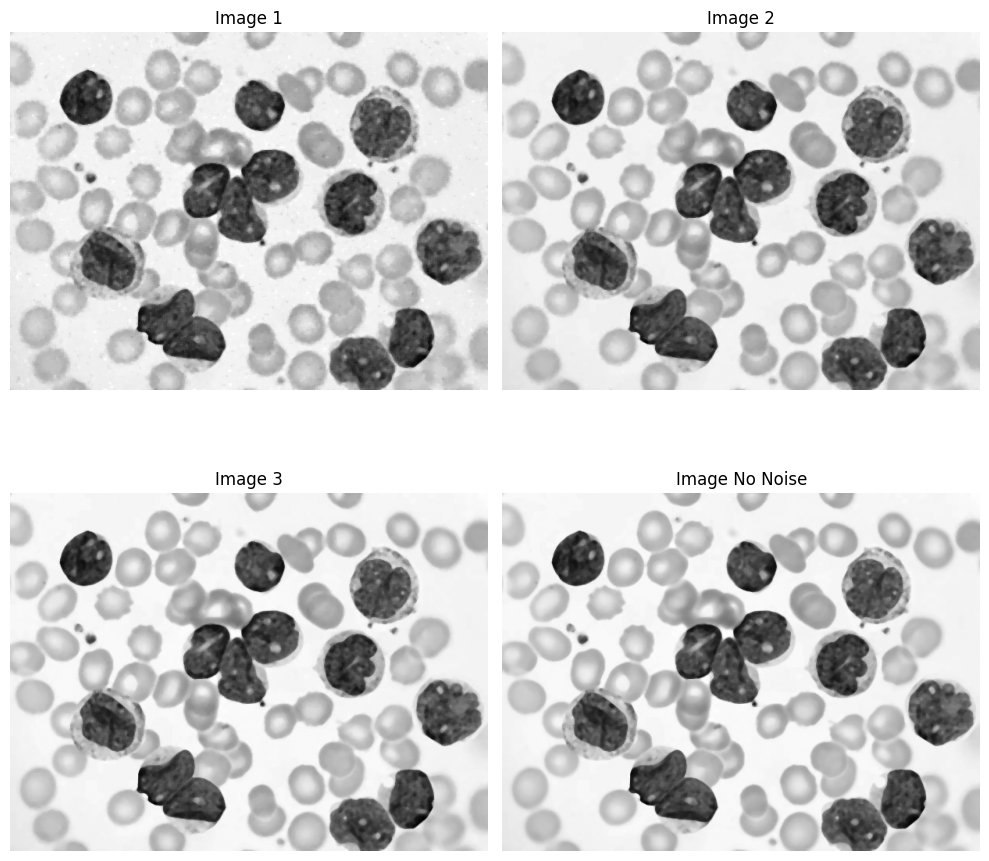

In [101]:
kernel_size = 5

blurred_image_MB_1 = cv2.medianBlur(img1, kernel_size, 0)
blurred_image_MB_2 = cv2.medianBlur(img2, kernel_size, 0)
blurred_image_MB_3 = cv2.medianBlur(img3, kernel_size, 0)
blurred_image_MB_NoNoise = cv2.medianBlur(img_nonoise, kernel_size, 0)

show_four_images(blurred_image_MB_1, blurred_image_MB_2, blurred_image_MB_3, blurred_image_MB_NoNoise)

### Non-Local Means

In [ ]:
blurred_image_nlm_1 = cv2.fastNlMeansDenoising(img1, None, 10, 7, 21)
blurred_image_nlm_2 = cv2.fastNlMeansDenoising(img2, None, 10, 7, 21)
blurred_image_nlm_3 = cv2.fastNlMeansDenoising(img3, None, 10, 7, 21)
blurred_image_nlm_NoNoise = cv2.fastNlMeansDenoising(img_nonoise, None, 10, 7, 21)

show_four_images(blurred_image_nlm_1, blurred_image_nlm_2, blurred_image_nlm_3, blurred_image_nlm_NoNoise)

On peut observer après l'utilisation de ces trois filtres que le plus efficace pour diminuer le bruit et séparer les cellules semble être le Median Filter. Nous allons donc utiliser les images filtrées par ce dernier pour les opérations suivantes.

### Seuillage

#### Méthode d'Otsu

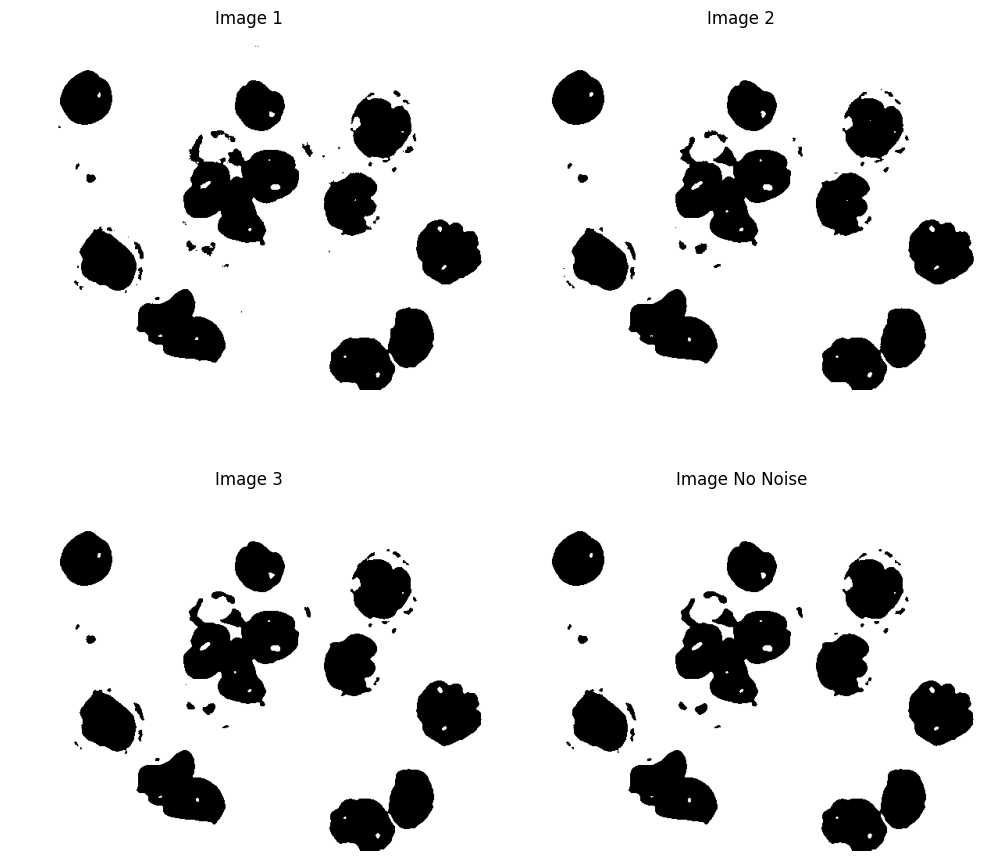

In [103]:
def compute_histogram(image):
    # Compute histogram manually
    histogram = np.zeros(256, dtype=int)  # Initialize array for 256 intensity values

    # Count pixel occurrences
    for pixel_value in image.flatten():  # Flatten the image to a 1D array
        histogram[pixel_value] += 1
    return histogram

def otsu_threshold(image):
    # Calcul de l'histogramme de l'image
    hist = compute_histogram(image)
    
    # Normalisation de l'histogramme pour obtenir les probabilités de chaque pixel
    total_pixels = image.size
    probas = hist / total_pixels # probabilité d'aparition pour chaque pixel
    
    # Calcul de la moyenne globale de l'image
    global_mean = np.mean(image)
    
    # Initialisation des variables pour le calcul du seuil optimal
    best_threshold = 0
    max_between_class_variance = 0
    
    # Variables pour stocker les informations sur les classes
    w0 = 0  # Poids de la première classe (pixels <= T)
    w1 = 0  # Poids de la deuxième classe (pixels > T)
    mean0 = 0  # Moyenne de la première classe
    mean1 = 0  # Moyenne de la deuxième classe

    for t in range(256):
        w0 += probas[t]  # Update weight of class 1
        if w0 == 0 or w0 == 1:  # Avoid division by zero
            continue
        w1 = 1 - w0  # Weight of class 2
        
        mean0 += t * probas[t]  # Update mean of class 1
        mean1 = (global_mean - mean0) / w1  # Compute mean of class 2
        
        # Compute between-class variance
        between_class_variance = w0 * w1 * (mean0 / w0 - mean1) ** 2

        # Check if the variance is maximized
        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            best_threshold = t
    
    # Apply threshold to create binary image
    binary_image = np.where(image > best_threshold, 255, 0).astype(np.uint8)
    
    return best_threshold, binary_image

best_threshold, img1_otsu = otsu_threshold(blurred_image_MB_1) 
best_threshold, img2_otsu = otsu_threshold(blurred_image_MB_2)
best_threshold, img3_otsu = otsu_threshold(blurred_image_MB_3)
best_threshold, img_nonoise_otsu = otsu_threshold(blurred_image_MB_NoNoise)

show_four_images(img1_otsu, img2_otsu, img3_otsu, img_nonoise_otsu)


### Ouverture

#### Erosion

In [104]:
def erosion(image, kernel):
    
    # Dimensions de l'image et du noyau
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calcul des bords à appliquer (padding)
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # Image avec padding autour pour éviter les erreurs lors de la convolution
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    # Image érodée (initialisée avec des zéros)
    eroded_image = np.zeros_like(image)
    
    # Convolution pour appliquer l'érosion
    for i in range(img_height):
        for j in range(img_width):
            # Extraire la région de l'image où appliquer le noyau
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            
            # Appliquer l'érosion (min de tous les pixels de la région sous le noyau)
            eroded_image[i, j] = np.min(region * kernel)
    
    return eroded_image.astype(np.uint8)

K = np.array([[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]])

K_bis = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]])

#### Dilatation

In [105]:
def dilatation(image, kernel):
    
    # Dimensions de l'image et du noyau
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calcul des bords à appliquer (padding)
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # Image avec padding autour pour éviter les erreurs lors de la convolution
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    # Image érodée (initialisée avec des zéros)
    dilated_image = np.zeros_like(image)
    
    # Convolution pour appliquer l'érosion
    for i in range(img_height):
        for j in range(img_width):
            # Extraire la région de l'image où appliquer le noyau
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            
            # Appliquer l'érosion (min de tous les pixels de la région sous le noyau)
            dilated_image[i, j] = np.max(region * kernel)
    
    return dilated_image.astype(np.uint8)

#### Ouverture

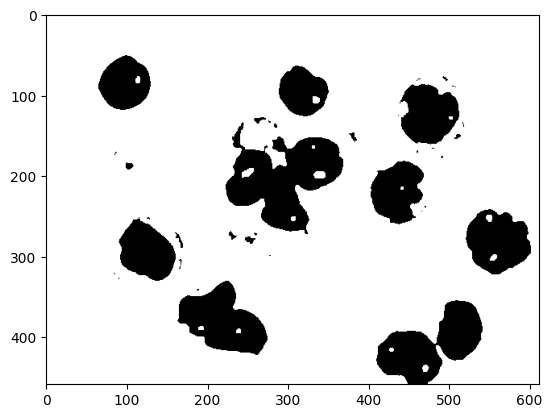

In [106]:
img1_ouvert = dilatation(img1_otsu, K)
plt.imshow(img1_ouvert, cmap='gray')

### Détection des contours

#### Algorithme de Canny

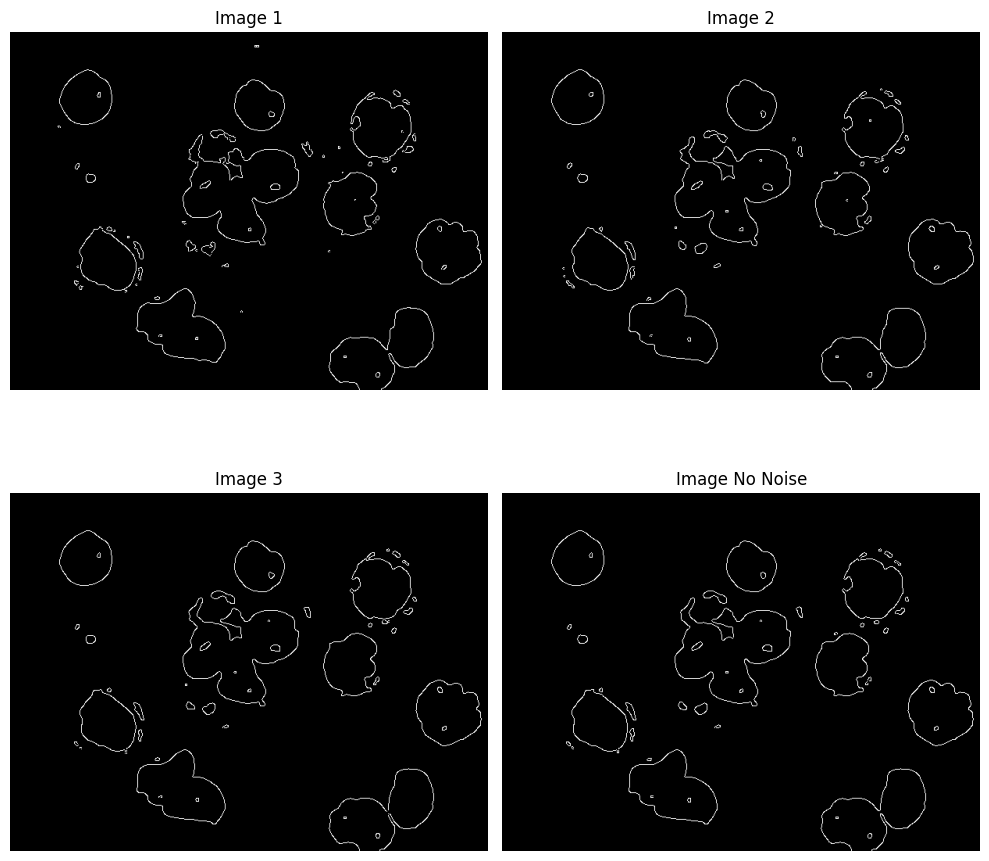

In [165]:
# Appliquer le détecteur de contours de Canny
edges1 = cv2.Canny(img1_otsu, 168, 200)
edges2 = cv2.Canny(img2_otsu, 100, 200)
edges3 = cv2.Canny(img3_otsu, 100, 200)
edgesNoNoise = cv2.Canny(img_nonoise_otsu, 100, 200)

show_four_images(edges1, edges2, edges3, edgesNoNoise)

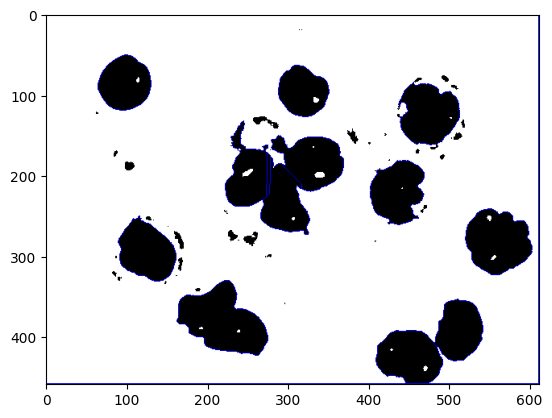

In [153]:
def watershed(image):
    # Apply binary thresholding (convert to black & white)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove small noise using morphological opening
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (dilate to get the background)
    sure_bg = cv2.dilate(opening, kernel, iterations=10)

    # Distance transform to find sure foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Identify unknown region (background - foreground)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Make sure background is not 0
    markers[unknown == 255] = 0  # Mark unknown region as 0

    # Apply the Watershed algorithm
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
    cv2.watershed(image_color, markers)
    image_color[markers == -1] = [0, 0, 255]  # Mark boundaries in red

    return image_color

watershed1 = watershed(img1_otsu)

plt.imshow(watershed1)

In [164]:
contours, _ = cv2.findContours(img1_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

Number of contours found: 3
